In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from sklearn.naive_bayes import GaussianNB
from pygal_maps_world.maps import World

In [2]:
data = sqlite3.connect('database.sqlite')
cur = data.cursor()
query = cur.execute(
    'select ascent.year, ascent.user_id, user.birth, grade.fra_routes, user.sex, user.height, user.weight, user.started\
        ,user.country from ascent, grade, user where ascent.grade_id = grade.id and ascent.user_id = user.id'
    )
cols = [column[0] for column in query.description]
df = pd.DataFrame.from_records(data=query.fetchall(), columns = cols)

In [3]:
print(df.head())
print('number of rows:',df.shape[0],'number of cols:',df.shape[1])

   year  user_id       birth fra_routes  sex  height  weight  started country
0  1999        1  1976-03-10         6a    0     177      73     1996     SWE
1  1999        1  1976-03-10         6a    0     177      73     1996     SWE
2  1999        1  1976-03-10         6a    0     177      73     1996     SWE
3  1999        1  1976-03-10         6a    0     177      73     1996     SWE
4  1999        1  1976-03-10         6a    0     177      73     1996     SWE
number of rows: 4110933 number of cols: 9


In [4]:
df = df.replace({
    'fra_routes' : '8c/+'
},{
    'fra_routes': '8c+'
})
df = df.replace({
    'fra_routes': '-',
    'started':0,
    'birth' :'',
    'weight' : 0,
    'height' : 0,
},{
    'fra_routes': np.NaN,
    'started':np.NaN,
    'birth':np.NaN,
    'weight':np.NaN,
    'height' : np.NaN
})
df=df.dropna(subset=['fra_routes'])

In [5]:
# Giving the grade ordinal value for analysis
grade = ['2','3a','3b','3c','4a','4b','4c','5a','5b','5c','6a','6a+','6b','6b+','6c','6c+',
        '7a','7a+','7b','7b+','7c','7c+','8a','8a+','8b','8b+','8c','8c+','8c+/9a','9a','9a+','9b','9b+','9c']
gradeRank=list(range(1,len(grade)+1))
df['grade'] = df['fra_routes'].copy()
df['grade'] = df['grade'].replace(grade, gradeRank)

In [6]:
df=df.dropna()

In [7]:
df['birth']=pd.to_datetime(df['birth'],format='%Y-%m-%d',errors='coerce')
df=df.dropna(subset=['birth'])
df['yearBorn'] = df['birth'].apply(lambda x : x.strftime('%Y'))

In [8]:
df_cleaned = df[df['height']>100]

In [9]:
df_cleaned.tail()

,year,user_id,birth,fra_routes,sex,height,weight,started,country,grade,yearBorn
4110927,2017,19775,1980-05-17,7a,1,157.0,48.0,2006.0,ZAF,17,1980
4110928,2017,59627,1987-11-25,6c+,0,180.0,68.0,2015.0,POL,16,1987
4110930,2017,19098,1980-05-28,7a+,0,163.0,58.0,2004.0,ESP,18,1980
4110931,2017,19098,1980-05-28,7c,0,163.0,58.0,2004.0,ESP,21,1980
4110932,2017,24751,1986-03-25,8a,0,166.0,58.0,2006.0,ESP,23,1986


In [10]:
df_cleaned['age']=df_cleaned.loc[:,'year']-df_cleaned.loc[:,'yearBorn'].astype(dtype=np.int64)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
df_cleaned = df_cleaned.drop(['birth'],axis=1)

In [12]:
df_cleaned.head()

,year,user_id,fra_routes,sex,height,weight,started,country,grade,yearBorn,age
0,1999,1,6a,0,177.0,73.0,1996.0,SWE,11,1976,23
1,1999,1,6a,0,177.0,73.0,1996.0,SWE,11,1976,23
2,1999,1,6a,0,177.0,73.0,1996.0,SWE,11,1976,23
3,1999,1,6a,0,177.0,73.0,1996.0,SWE,11,1976,23
4,1999,1,6a,0,177.0,73.0,1996.0,SWE,11,1976,23


In [13]:
df_cleaned.loc[df_cleaned['grade'].where(df_cleaned['user_id']==4).idxmax(),'year']

2008

In [14]:
climbs = df_cleaned['user_id'].value_counts()

In [15]:
#Combine log by each user
listed_df = df_cleaned.groupby(['user_id']).agg(lambda x :x.unique().tolist())

In [16]:
listed_df.head()

,year,fra_routes,sex,height,weight,started,country,grade,yearBorn,age
user_id,,,,,,,,,,
1,"[1999, 1998, 2000, 2001, 2002, 2003, 2004, 2005]","[6a, 6a+, 6b, 6b+, 6c, 6c+, 7a, 7a+, 7b, 7b+, ...",[0],[177.0],[73.0],[1996.0],[SWE],"[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2...",[1976],"[23, 22, 24, 25, 26, 27, 28, 29]"
3,"[1999, 1998, 1997, 1996, 1995, 2000, 2001]","[7b+, 7a, 8a, 7a+, 7b, 7c, 7c+, 6c+, 6c]",[0],[180.0],[78.0],[1995.0],[SWE],"[20, 17, 23, 18, 19, 21, 22, 16, 15]",[1973],"[26, 25, 24, 23, 22, 27, 28]"
4,"[2004, 2003, 2005, 2006, 2007, 2008, 2009]","[8a, 7c, 7b, 7a+, 7b+, 7c+, 7a, 6c, 6c+, 6a+, ...",[1],[165.0],[58.0],[2001.0],[SWE],"[23, 21, 19, 18, 20, 22, 17, 15, 16, 12, 14, 1...",[1984],"[20, 19, 21, 22, 23, 24, 25]"
6,"[2000, 2001]","[7c, 8a, 7c+, 7b, 8a+, 7b+]",[0],[185.0],[73.0],[1992.0],[AUS],"[21, 23, 22, 19, 24, 20]",[1970],"[30, 31]"
10,"[2000, 1993, 1999, 2002, 1995, 1996, 1998, 199...","[7b, 7b+, 7a+, 7a, 8a, 7c+, 7c, 8a+, 5c, 6b+, ...",[0],[167.0],[63.0],[1992.0],[SWE],"[19, 20, 18, 17, 23, 22, 21, 24, 10, 14, 13, 1...",[1965],"[35, 28, 34, 37, 30, 31, 33, 32, 29, 27, 36, 3..."


In [17]:
#Sorting the grade list so I can take the max grade climbed by the user
result = listed_df.fra_routes.sort_values().apply(lambda x: sorted(x))

In [18]:
for i in listed_df.index:
    listed_df['fra_routes'][i]=result[i]

In [19]:
# for i in listed_df.index:
#     listed_df['year'][i] = df_cleaned.loc[df_cleaned['grade'].where(df_cleaned['user_id']==i).idxmax(),'year']

## Because the above code took too long to run, I used the percentile of year to get peak year

In [20]:
for i in listed_df.index:
    listed_df['year'][i]=np.percentile(listed_df['year'][i],75)
    listed_df['fra_routes'][i]=listed_df['fra_routes'][i][-1]
    listed_df['sex'][i]=listed_df['sex'][i][0]
    listed_df['height'][i]=listed_df['height'][i][0]
    listed_df['weight'][i]=listed_df['weight'][i][0]
    listed_df['started'][i]=listed_df['started'][i][0]
    listed_df['grade'][i]=max(listed_df['grade'][i])
    listed_df['yearBorn'][i]=listed_df['yearBorn'][i][0]
    listed_df['country'][i]=listed_df['country'][i][0]
    listed_df['age'][i]=np.percentile(listed_df['age'][i],75)

In [21]:
listed_df.head()

,year,fra_routes,sex,height,weight,started,country,grade,yearBorn,age
user_id,,,,,,,,,,
1,2003.25,8a,0,177,73,1996,SWE,23,1976,27.25
3,1999.5,8a,0,180,78,1995,SWE,23,1973,26.5
4,2007.5,8a+,1,165,58,2001,SWE,24,1984,23.5
6,2000.75,8a+,0,185,73,1992,AUS,24,1970,30.75
10,2010.75,8a+,0,167,63,1992,SWE,24,1965,45.75


In [22]:
dfuser = listed_df.drop(['year','started','fra_routes','height','weight','started','grade','yearBorn'], axis=1)
print(dfuser.head())

        sex country    age
user_id                   
1         0     SWE  27.25
3         0     SWE   26.5
4         1     SWE   23.5
6         0     AUS  30.75
10        0     SWE  45.75


In [23]:
dfuser = dfuser.replace({
    'country' : ['','none','-']
},{
    'country': 'np.NaN'
})
dfuser = dfuser.dropna(subset=['country'])

In [55]:
country = dfuser['country'].value_counts()
countrylist = list(df['country'].unique())

In [25]:
countrylist.remove('BMU')
countrylist.remove('YUG')
countrylist.remove('WSM')
countrylist.remove('FXX')
countrylist.remove('PYF')
countrylist.remove('MSR')
countrylist.remove('PLW')
countrylist.remove('SMO')
countrylist.remove('QAT')
countrylist.remove('CIV')
countrylist.remove('ABW')
countrylist.remove('GTM')
countrylist.remove('NFK')
countrylist.remove('STP')
countrylist.remove('ARE')
countrylist.remove('FRO')
countrylist.remove('DOM')
countrylist.remove('NCL')
countrylist.remove('VGB')
countrylist.remove('')
countrylist.remove('none')
countrylist.remove('ATF')

In [26]:
pygalList=[
         'se','au','no','be','nz','nl','ca','us','de','it','fr','pl','gb','co','my','cz','es','pt','at','za','hr','ch','ph',
         'mx','gr','br','rs','si','bg','dk','hk','ie','il','ga','ru','ro','fi','sg','jp','pe','ua','zw','af','lt','lu','kr',
         'bo','tw','ar','ir','hu','in','tr','ng','tj','hn','vn','cl','ad','th','ee','mn','ec','ve','sk','cn','re','bz','is',
         'lv','mv','mk','gu','np','na','kz','gh','by','et','ba','id','pr','kg','pa','ao','ug','om','mt','al','lb','ge'
        ]
dfmap = dfuser.country.replace(countrylist, pygalList)
dfmap = dfmap[dfmap.isin(pygalList)]
mappingDict = dict(dfmap.value_counts())

In [54]:
wmChart = World()
wmChart.title = 'Number of Users in Each Country'
wmChart.add('Climbers',mappingDict)
wmChart.render_to_file('usermap.svg')

## Preparing dataframe for machine learning

In [28]:
final_df = listed_df.drop(['year','started','fra_routes','country'],axis=1)
final_df['climbExp'] = listed_df['year']-listed_df['started']

In [29]:
final_df = final_df.astype(dtype=np.int64)

In [30]:
final_df['BMI'] = final_df['weight']/((final_df['height']/100)**2)

In [31]:
final_df.head()

,sex,height,weight,grade,yearBorn,age,climbExp,BMI
user_id,,,,,,,,
1,0,177,73,23,1976,27,7,23.301095
3,0,180,78,23,1973,26,4,24.074074
4,1,165,58,24,1984,23,6,21.303949
6,0,185,73,24,1970,30,8,21.329438
10,0,167,63,24,1965,45,18,22.589551


# Grade classification (Nick Draper, University of Derby)

![](Classification.png) 

In [32]:
conditions = [
    (final_df['grade'] <=9),
    (final_df['grade'] <=17),
    (final_df['grade'] <=23),
    (final_df['grade'] <=27),
    (final_df['grade'] <=32)
    ]
choices = [1, 2, 3, 4, 5]
final_df['class'] = np.select(conditions, choices)
target_names = ['Lower Grade','Intermediate', 'Advanced', 'Elite','Higher Elite']

In [33]:
mldf = final_df[final_df['climbExp']>=0]
mldf = mldf[mldf['climbExp']<=20]
mldf = mldf[mldf['age']<60]
mldf = mldf[mldf['age']>18]
mldf = mldf[mldf['age']>mldf['climbExp']]
mldf = mldf[mldf['grade']>11]
mldf = mldf[mldf['height']<200]
mldf = mldf[mldf['height']>100]
mldf = mldf[mldf['BMI']<35]
mldf = mldf[mldf['BMI']>16]
#climbing experience > 20 might be false data
#age < climbExp False data from user
#low climbing grade with high exp might be from inactive user
#many false data from user with age more than 100
#BMI>29.9 is considered obesity, so it might be false height and weight data from user

In [34]:
mldf = mldf.join(climbs).rename(columns={'user_id':'climbLogged'})

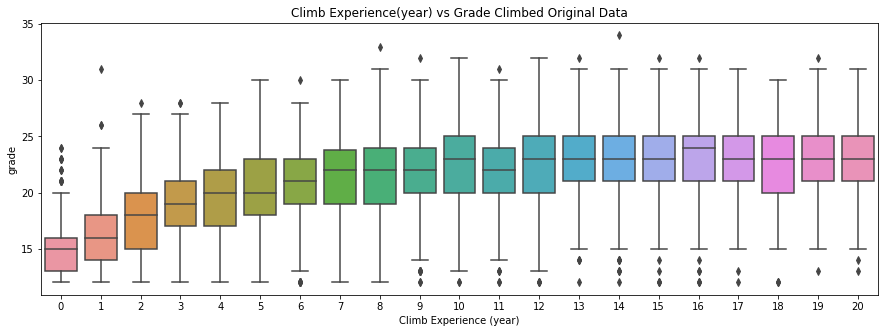

In [35]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(x="climbExp", y="grade", data=mldf)
plt.title('Climb Experience(year) vs Grade Climbed Original Data')
plt.xlabel('Climb Experience (year)')
plt.show()

# Filtering user false data

In [36]:
ff = mldf[mldf['climbExp']==1].where(mldf['grade']<=14)
ff = ff.dropna()
ff2 = mldf[mldf['climbExp']==2].where(mldf['grade']<=16)
ff2= ff2.dropna()
ff3 = mldf[mldf['climbExp']<=18].where(mldf['climbLogged']>50)
ff3= ff3[ff3['climbExp']>2]
ff4 = mldf[mldf['climbExp']==0].where(mldf['grade']<=13).where(mldf['climbLogged']<10)

In [37]:
ffjoin = pd.concat([ff,ff2,ff3,ff4])

In [38]:
ffjoin.head()

,sex,height,weight,grade,yearBorn,age,climbExp,BMI,class,climbLogged
user_id,,,,,,,,,,
556,0.0,180.0,78.0,13.0,1979.0,22.0,1.0,24.074074,2.0,10.0
1058,0.0,180.0,78.0,14.0,1978.0,24.0,1.0,24.074074,2.0,54.0
1392,0.0,180.0,73.0,13.0,1980.0,21.0,1.0,22.530864,2.0,18.0
1995,0.0,165.0,63.0,13.0,1969.0,33.0,1.0,23.140496,2.0,40.0
2045,0.0,196.0,83.0,13.0,1975.0,27.0,1.0,21.605581,2.0,1.0


In [39]:
final_mldf = ffjoin[ffjoin['climbLogged']<1000]

In [40]:
#Removing outlier
z = np.abs(stats.zscore(final_mldf))
threshold = 3
final_mldf0 = final_mldf[(z < 3).all(axis=1)]

In [41]:
final_mldf0.corr()

,sex,height,weight,grade,yearBorn,age,climbExp,BMI,class,climbLogged
sex,1.000000,-0.529320,-0.557770,-0.136155,-0.010819,0.011296,-0.060056,-0.347046,-0.125961,-0.073001
height,-0.529320,1.000000,0.753689,-0.024042,0.009940,-0.018912,-0.017617,0.134442,-0.033480,0.018734
weight,-0.557770,0.753689,1.000000,-0.130253,-0.105342,0.092567,-0.017499,0.749273,-0.132007,-0.016749
grade,-0.136155,-0.024042,-0.130253,1.000000,0.153969,-0.084050,0.559977,-0.161984,0.909366,0.473058
yearBorn,-0.010819,0.009940,-0.105342,0.153969,1.000000,-0.830326,-0.257227,-0.165241,0.147494,0.005604
age,0.011296,-0.018912,0.092567,-0.084050,-0.830326,1.000000,0.317716,0.154717,-0.089324,0.147801
climbExp,-0.060056,-0.017617,-0.017499,0.559977,-0.257227,0.317716,1.000000,-0.004458,0.512631,0.380447
BMI,-0.347046,0.134442,0.749273,-0.161984,-0.165241,0.154717,-0.004458,1.000000,-0.155823,-0.038783
class,-0.125961,-0.033480,-0.132007,0.909366,0.147494,-0.089324,0.512631,-0.155823,1.000000,0.437884
climbLogged,-0.073001,0.018734,-0.016749,0.473058,0.005604,0.147801,0.380447,-0.038783,0.437884,1.000000


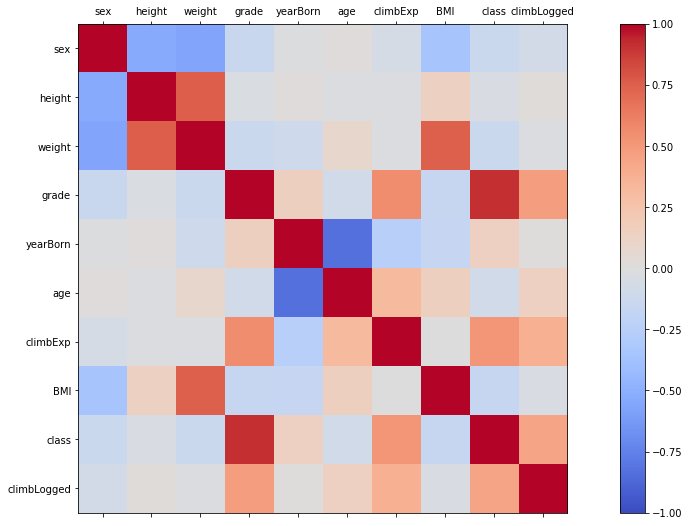

In [69]:
fig = plt.figure(figsize=(19,9))
ax = fig.add_subplot(111)
cax = ax.matshow(final_mldf0.corr(), vmin=-1, vmax=1, cmap='coolwarm')
fig.colorbar(cax)
ticks = np.arange(0,10,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(['sex','height','weight','grade','yearBorn','age','climbExp','BMI','class','climbLogged'])
ax.set_yticklabels(['sex','height','weight','grade','yearBorn','age','climbExp','BMI','class','climbLogged'])
plt.show()

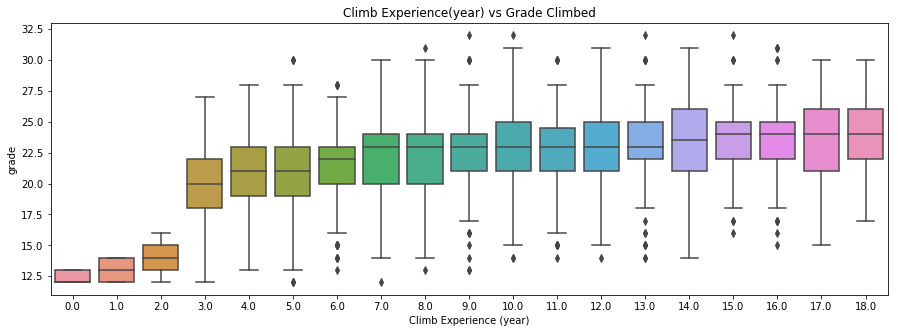

In [57]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(x="climbExp", y="grade", data=final_mldf0)
plt.title('Climb Experience(year) vs Grade Climbed')
plt.xlabel('Climb Experience (year)')
plt.show()

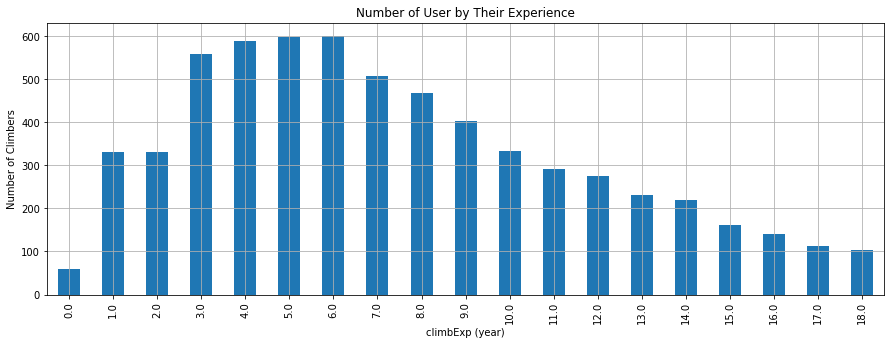

In [70]:
plt.figure(figsize=(15,5))
# ax = sns.boxplot(x="climbExp", y="class", data=final_mldf0)
expdist = final_mldf0['climbExp'].value_counts().sort_index()
expdist.plot(kind='bar')
plt.title('Number of User by Their Experience')
plt.xlabel('climbExp (year)')
plt.ylabel('Number of Climbers')
plt.grid()
plt.show()

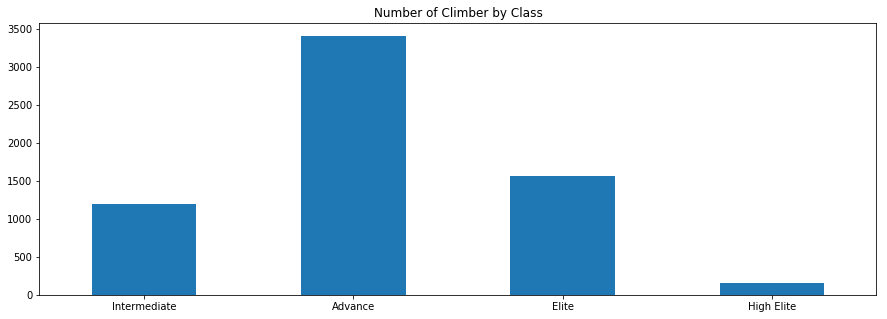

In [44]:
plt.figure(figsize=(15,5))
# ax = sns.boxplot(x="climbExp", y="class", data=final_mldf0)
classdist = final_mldf0['class'].value_counts().sort_index()
classdist.plot(kind='bar')
plt.xticks(np.arange(4),('Intermediate','Advance','Elite','High Elite'),rotation=0)
plt.title('Number of Climber by Class')
plt.show()

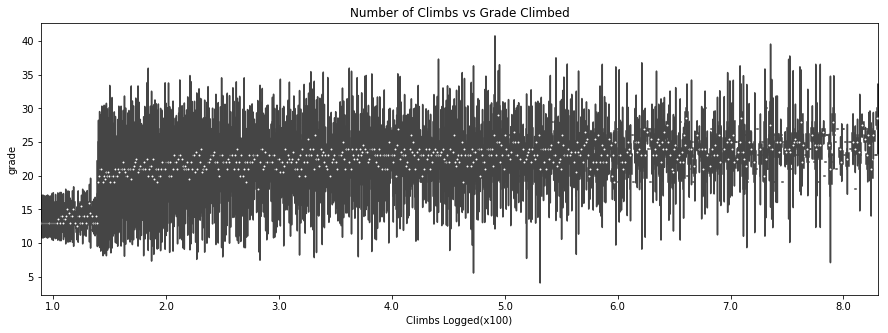

In [63]:
plt.figure(figsize=(15,5))
ax = sns.violinplot(x="climbLogged", y="grade", data=final_mldf0)
plt.title('Number of Climbs vs Grade Climbed')
plt.xlabel('Climbs Logged(x100)')
plt.xticks(np.arange(10,800,100))
plt.show()

Text(0.5,1,'Scatter Plot of number Climbs Logged vs User Peak Grade')

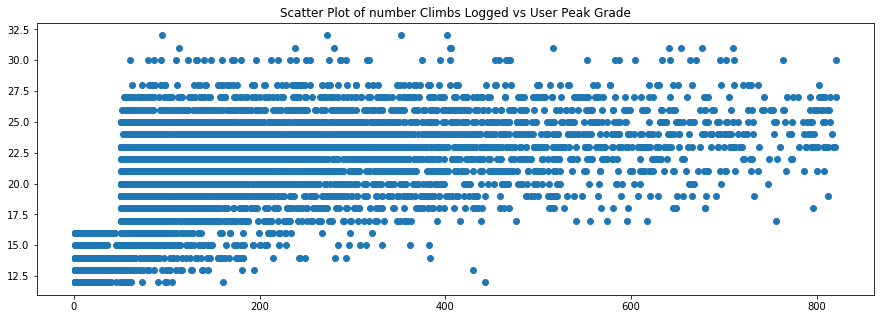

In [46]:
plt.figure(figsize=(15,5))
plt.scatter(final_mldf0['climbLogged'], final_mldf0['grade'])
plt.title('Scatter Plot of number Climbs Logged vs User Peak Grade')

### Data train and test Splitting

In [47]:
x_train, x_test, y_train, y_test = train_test_split(
    final_mldf0[['climbExp','climbLogged','BMI']],
    final_mldf0['class'],
    test_size=.2,
)

In [48]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train,y_train)
print(rf.score(x_test,y_test))

0.627870150435


In [49]:
# Best on 3 var

logreg = LogisticRegression()
logreg.fit(x_train,y_train)
print(logreg.score(x_test,y_test))

0.668250197941


In [50]:
svmodel = SVC(gamma='auto',C=1000)
svmodel.fit(x_train,y_train)
print(svmodel.score(x_test,y_test))

0.538400633413


In [51]:
knn = KNeighborsClassifier(n_neighbors=1000)
knn.fit(x_train, y_train)
print(knn.score(x_test,y_test))


0.633412509897


In [52]:
nb=GaussianNB()
nb.fit(x_train,y_train)
print(nb.score(x_test,y_test))

0.621536025337


In [53]:
def predict(x,y,z):
    return int(logreg.predict([[x,y,z]]))
x = int(input('Climb experience(year): '))
y = int(input('Routes climbed: '))
z = float(input('BMI: '))
target_names[predict(x,y,z)]

Climb experience(year): 7
Routes climbed: 22
BMI: 18.5


'Elite'